<a href="https://colab.research.google.com/github/rachocr/CCDATSCL_PROJECT/blob/main/FINALS_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load and Import Libraries

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import glob, os, shutil, warnings

# Suppress warnings for clean output
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('future.no_silent_downcasting', True)

# Professional Visualization Theme
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Loading and Importing Libraries Completed.")

Loading and Importing Libraries Completed.


## Load, Merge, and Explore Dataset

In [102]:
# 1. Refresh Repository
repo_path = 'CCDATSCL_PROJECT'
if os.path.exists(repo_path):
    shutil.rmtree(repo_path)
!git clone https://github.com/rachocr/CCDATSCL_PROJECT.git

# 2. Master Keyword Mapping (Standardizes all 9 weeks)
master_columns = {
    'date': 'Date', 'intake': 'Coffee_Intake', 'caffeine': 'Caffeine_Amount_mg',
    'type': 'Type_of_Coffee', 'brand': 'Brand', 'flavor': 'Flavor',
    'sugar': 'Sugar_Level', 'creamer': 'Creamer_Level', 'focus': 'Focus_Rating',
    'duration': 'Productivity_Duration', 'sleep': 'Sleep_Hours',
    'tasks_completed': 'Tasks_Completed', 'tasks_note': 'Tasks_Note'
}

csv_files = sorted(glob.glob('CCDATSCL_PROJECT/Dataset/Week *.csv'))
week_dfs = []

print("\n📂 Standardizing and Merging 9 Weeks of Data:")
for file in csv_files:
    df_temp = pd.read_csv(file)
    new_cols = []
    for col in df_temp.columns:
        clean_col = col.lower().replace(' ', '_')
        found = False
        for key, master_name in master_columns.items():
            if key in clean_col:
                new_cols.append(master_name); found = True; break
        if not found: new_cols.append(clean_col)
    df_temp.columns = new_cols
    week_dfs.append(df_temp)

merged_df = pd.concat(week_dfs, ignore_index=True)
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

print(f"✅ Merged Success. Rows: {len(merged_df)}")

Cloning into 'CCDATSCL_PROJECT'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 66 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 587.75 KiB | 8.40 MiB/s, done.
Resolving deltas: 100% (16/16), done.

📂 Standardizing and Merging 9 Weeks of Data:
✅ Merged Success. Rows: 65


In [103]:
display(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Date                   65 non-null     object
 1   Coffee_Intake          65 non-null     int64 
 2   Caffeine_Amount_mg     65 non-null     int64 
 3   Type_of_Coffee         59 non-null     object
 4   Brand                  59 non-null     object
 5   Flavor                 59 non-null     object
 6   Sugar_Level            59 non-null     object
 7   Creamer_Level          59 non-null     object
 8   Focus_Rating           65 non-null     int64 
 9   Productivity_Duration  65 non-null     int64 
 10  Sleep_Hours            65 non-null     int64 
 11  Tasks_Completed        65 non-null     int64 
 12  Tasks_Note             65 non-null     object
dtypes: int64(6), object(7)
memory usage: 6.7+ KB


None

In [104]:
display(merged_df.head())

,Date,Coffee_Intake,Caffeine_Amount_mg,Type_of_Coffee,Brand,Flavor,Sugar_Level,Creamer_Level,Focus_Rating,Productivity_Duration,Sleep_Hours,Tasks_Completed,Tasks_Note
0,06/12/2025,16,120,Latte,Grill & Grind,Spanish Latte,Medium,Medium,3,4,10,3,"Fix motorcycle, Clean House, Pet Medication"
1,07/12/2025,24,297,Brewed,Dunkin' Donut,Iced Coffee,Medium,Medium,4,3,9,2,"Studying Java, Pet Medication"
2,08/12/2025,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,3,2,6,2,"Fix motorcycle, Pet Medication"
3,09/12/2025,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,3,2,7,2,"Studying Java, Pet Medication"
4,10/12/2025,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,4,2,9,3,"Studying Java, Pet Medication, Applied Interns..."


In [105]:
display(merged_df.tail())

,Date,Coffee_Intake,Caffeine_Amount_mg,Type_of_Coffee,Brand,Flavor,Sugar_Level,Creamer_Level,Focus_Rating,Productivity_Duration,Sleep_Hours,Tasks_Completed,Tasks_Note
60,04/02/2026,16,120,Latte,Kape at Musika,Spanish Latte,High,High,4,6,7,5,"Fixed Motorcycle, Adjusted my CV/Resume, Made ..."
61,05/02/2026,16,150,Latte,Pickup Coffee,Iced Sea Salt Latte,Medium,Medium,3,5,6,4,"Setup my PC, Checked and Validated the Prototy..."
62,06/02/2026,16,120,Latte,Pickup Coffee,Kasturi,High,High,3,5,7,4,"Meeting with Thesis Group, Dry run for hours, ..."
63,07/02/2026,16,120,Latte,Kape at Musika,Vanilla Latte,Medium,Medium,3,9,8,4,"Studied Regression Models for Thesis, Made not..."
64,08/02/2026,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,4,3,9,2,Celebritory Favorite Coffee for last week of D...


In [106]:
display(merged_df.describe())

,Coffee_Intake,Caffeine_Amount_mg,Focus_Rating,Productivity_Duration,Sleep_Hours,Tasks_Completed
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,14.738462,130.046154,3.353846,5.323077,7.538462,4.600000
std,5.964156,75.102104,1.242864,2.405123,1.562019,2.141845
min,0.000000,0.000000,1.000000,0.000000,5.000000,0.000000
25%,16.000000,110.000000,3.000000,3.000000,7.000000,3.000000
50%,16.000000,120.000000,3.000000,5.000000,7.000000,4.000000
75%,16.000000,150.000000,4.000000,7.000000,8.000000,6.000000
max,24.000000,320.000000,5.000000,11.000000,13.000000,10.000000


In [107]:
display(merged_df.isna().sum())

,0
Date,0
Coffee_Intake,0
Caffeine_Amount_mg,0
Type_of_Coffee,6
Brand,6
Flavor,6
Sugar_Level,6
Creamer_Level,6
Focus_Rating,0
Productivity_Duration,0


## Data Cleaning and Preprocessing

In [109]:
# Mappings
sugar_map = {'Low': 12.5, 'Medium': 22.5, 'High': 40.0}
coffee_type_map = {'Cold Brew': 'Brewed', 'Matcha': 'Latte', 'Americano': 'Espresso', 'Frappuccino': 'Latte'}
intensity_order = ['Low', 'Medium', 'High']

# METHOD CHAINING: Clean, Transform, and Discretize in one block
df_clean = (
    merged_df
    # 1. Standardize Text first
    .replace({'Type_of_Coffee': coffee_type_map})
    .fillna({'Type_of_Coffee': 'No Coffee', 'Sugar_Level': 'Low'})
    .assign(
        Date = lambda x: pd.to_datetime(x['Date'], dayfirst=True),
        Sleep_Hours = lambda x: pd.to_numeric(x['Sleep_Hours'], errors='coerce'),
        Caffeine_Amount_mg = lambda x: pd.to_numeric(x['Caffeine_Amount_mg'], errors='coerce'),
        Tasks_Completed = lambda x: pd.to_numeric(x['Tasks_Completed'], errors='coerce'),
        Coffee_Intake = lambda x: pd.to_numeric(x['Coffee_Intake'], errors='coerce'),

        # 2. Create Numeric Sugar Column (For Math/ML)
        Est_Sugar_g = lambda x: x['Sugar_Level'].map(sugar_map).fillna(0),

        # 3. Create Categorical Sugar Level (For Human Tables)
        # We enforce the order Low -> Medium -> High
        Sugar_Level = lambda x: pd.Categorical(x['Sugar_Level'], categories=intensity_order, ordered=True),

        # 4. Create Categorical Caffeine Level (For Human Tables)
        # Groups raw numbers (e.g. 120, 140) into bins
        Caffeine_Level = lambda x: pd.Categorical(
            pd.cut(x['Caffeine_Amount_mg'], bins=[0.1, 100, 200, 1000], labels=intensity_order),
            categories=intensity_order, ordered=True
        )
    )
    .dropna(subset=['Tasks_Completed'])
)

print("Data Cleaning and Preprocessing Completed.")
display(df_clean.head())

Data Cleaning and Preprocessing Completed.


,Date,Coffee_Intake,Caffeine_Amount_mg,Type_of_Coffee,Brand,Flavor,Sugar_Level,Creamer_Level,Focus_Rating,Productivity_Duration,Sleep_Hours,Tasks_Completed,Tasks_Note,Est_Sugar_g,Caffeine_Level
0,2025-12-06,16,120,Latte,Grill & Grind,Spanish Latte,Medium,Medium,3,4,10,3,"Fix motorcycle, Clean House, Pet Medication",22.5,Medium
1,2025-12-07,24,297,Brewed,Dunkin' Donut,Iced Coffee,Medium,Medium,4,3,9,2,"Studying Java, Pet Medication",22.5,High
2,2025-12-08,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,3,2,6,2,"Fix motorcycle, Pet Medication",22.5,Medium
3,2025-12-09,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,3,2,7,2,"Studying Java, Pet Medication",22.5,Medium
4,2025-12-10,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,4,2,9,3,"Studying Java, Pet Medication, Applied Interns...",22.5,Medium


## Exploratory Data Analysis

In [112]:
print("Statistical Summary")
summary_stats = df_clean[['Caffeine_Amount_mg', 'Tasks_Completed', 'Sleep_Hours']].agg(['mean', 'median', 'std', 'max']).round(2)
display(summary_stats)

Statistical Summary


,Caffeine_Amount_mg,Tasks_Completed,Sleep_Hours
mean,130.05,4.60,7.54
median,120.00,4.00,7.00
std,75.10,2.14,1.56
max,320.00,10.00,13.00


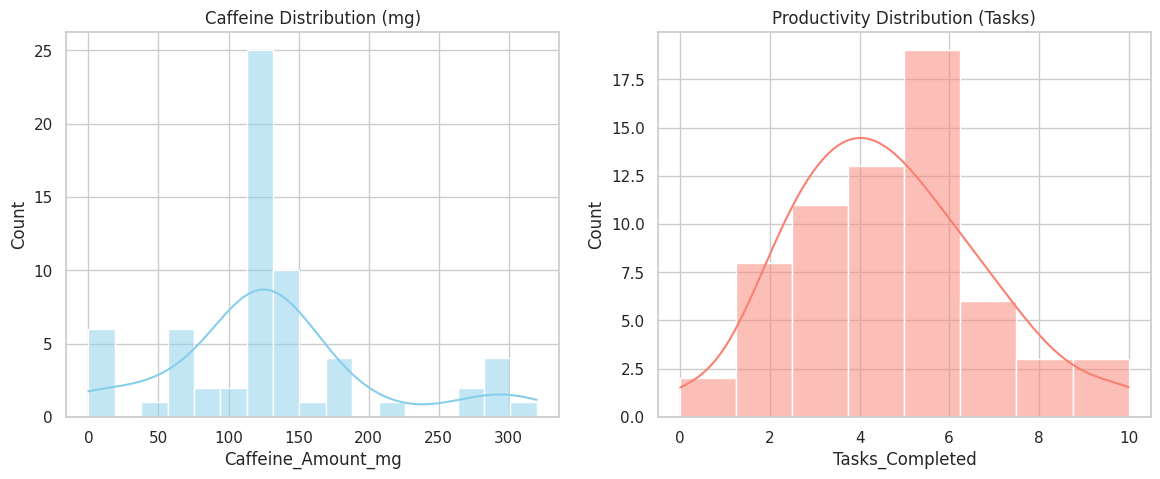

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_clean['Caffeine_Amount_mg'], kde=True, ax=axes[0], color='skyblue').set_title('Caffeine Distribution (mg)')
sns.histplot(df_clean['Tasks_Completed'], kde=True, ax=axes[1], color='salmon').set_title('Productivity Distribution (Tasks)')
plt.show()

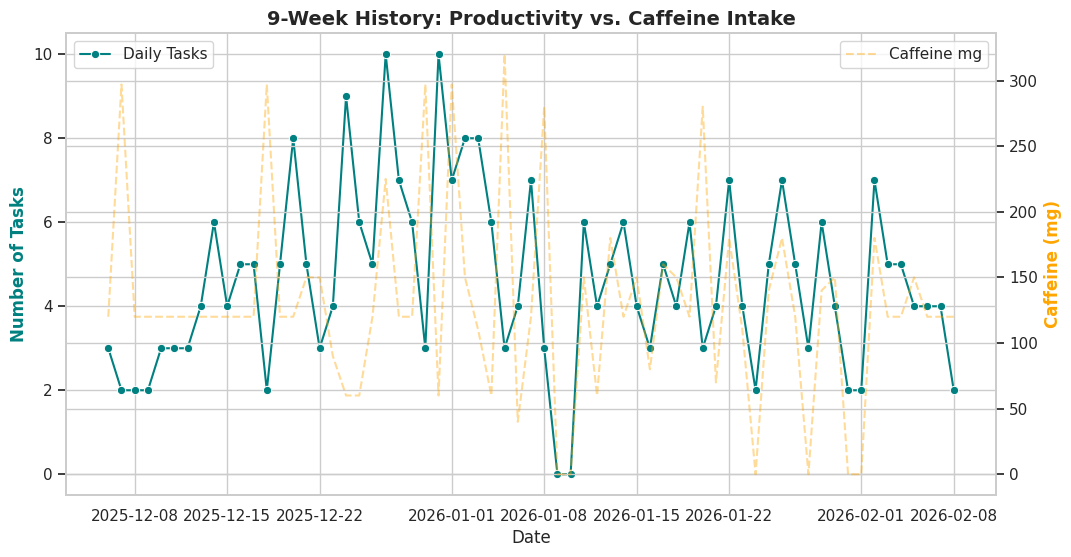

In [114]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=df_clean, x='Date', y='Tasks_Completed', color='teal', label='Daily Tasks', ax=ax1, marker='o')
ax1.set_ylabel('Number of Tasks', color='teal', fontweight='bold')

ax2 = ax1.twinx()
sns.lineplot(data=df_clean, x='Date', y='Caffeine_Amount_mg', color='orange', label='Caffeine mg', ax=ax2, alpha=0.4, ls='--')
ax2.set_ylabel('Caffeine (mg)', color='orange', fontweight='bold')

plt.title('9-Week History: Productivity vs. Caffeine Intake', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.show()

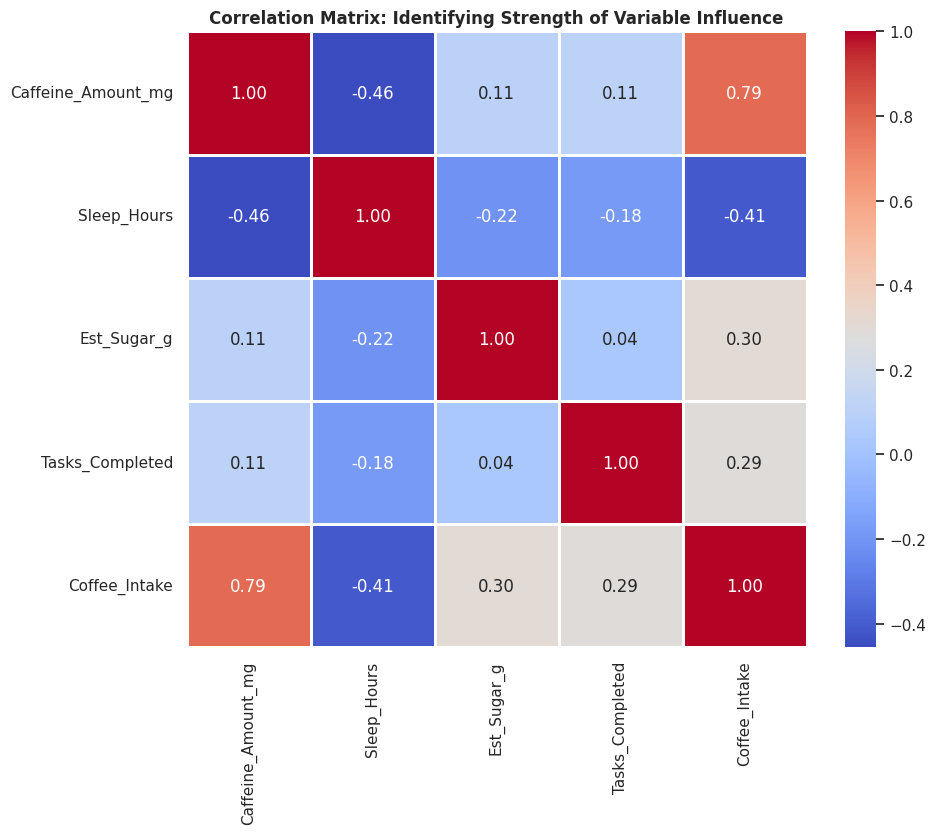

In [115]:
plt.figure(figsize=(10, 8))
# Calculating correlation only on relevant numeric columns
corr_matrix = df_clean[['Caffeine_Amount_mg', 'Sleep_Hours', 'Est_Sugar_g', 'Tasks_Completed', 'Coffee_Intake']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1)
plt.title('Correlation Matrix: Identifying Strength of Variable Influence', fontweight='bold')
plt.show()

In [117]:
# 1. KPI Dashboard
print("EXECUTIVE SUMMARY")
kpis = pd.DataFrame({
    "Metric": ["Total Days", "Avg Productivity", "Max Productivity", "Avg Sleep"],
    "Value": [
        len(df_clean),
        f"{df_clean['Tasks_Completed'].mean():.2f} Tasks/Day",
        f"{df_clean['Tasks_Completed'].max()} Tasks",
        f"{df_clean['Sleep_Hours'].mean():.2f} Hours"
    ]
})
display(kpis)

# 2. Pivot Table (Now shows Low/Medium/High for BOTH headers)
print("\nSUMMARY TABLE: Productivity by Sugar & Caffeine Level")
pivot_view = df_clean.pivot_table(
    index='Caffeine_Level',
    columns='Sugar_Level',
    values='Tasks_Completed',
    aggfunc='mean',
    observed=False
).round(2)

display(pivot_view)

EXECUTIVE SUMMARY


,Metric,Value
0,Total Days,65
1,Avg Productivity,4.60 Tasks/Day
2,Max Productivity,10 Tasks
3,Avg Sleep,7.54 Hours



SUMMARY TABLE: Productivity by Sugar & Caffeine Level


Sugar_Level,Low,Medium,High
Caffeine_Level,,,
Low,6.25,5.50,3.0
Medium,6.00,4.62,5.1
High,5.33,3.50,3.0


## Inferential Statistics

In [121]:
# H01: Caffeine (Linear Test)
r_coeff, p_corr = stats.pearsonr(df_clean['Caffeine_Amount_mg'], df_clean['Tasks_Completed'])

# H02: Coffee Ritual (Categorical Test)
# PANDAS MAXIMIZATION: Using .query() to filter groups cleanly
coffee_types = df_clean['Type_of_Coffee'].unique()
groups = [df_clean.query("Type_of_Coffee == @ctype")['Tasks_Completed'] for ctype in coffee_types]

f_stat, p_anova = stats.f_oneway(*groups)

results = pd.DataFrame([
    {"Hypothesis": "H01 (Caffeine Dose)", "P-value": f"{p_corr:.4f}", "Result": "Reject H0" if p_corr < 0.05 else "Fail to Reject H0"},
    {"Hypothesis": "H02 (Coffee Ritual)", "P-value": f"{p_anova:.4f}", "Result": "Reject H0" if p_anova < 0.05 else "Fail to Reject H0"}
])
print("Statistical Hypothesis Summary")
display(results)

Statistical Hypothesis Summary


,Hypothesis,P-value,Result
0,H01 (Caffeine Dose),0.3781,Fail to Reject H0
1,H02 (Coffee Ritual),0.0011,Reject H0


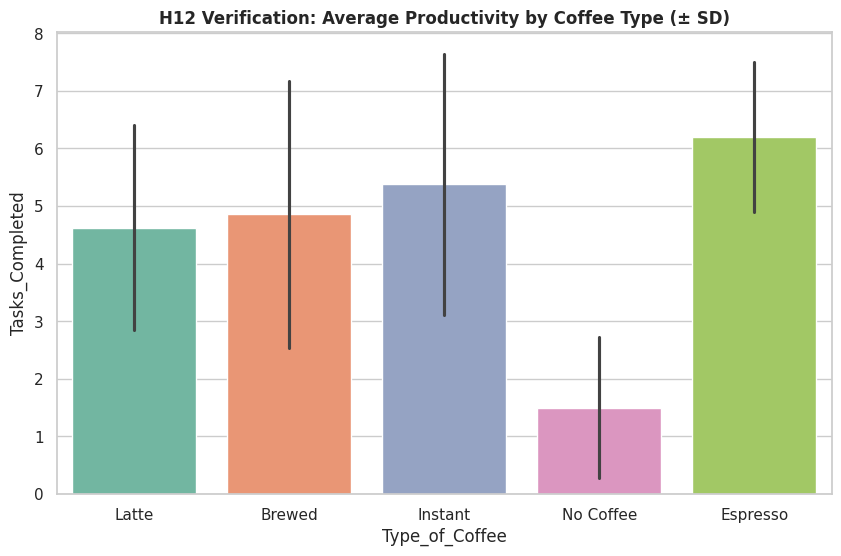

In [120]:
# Visualization for H12
plt.figure(figsize=(10, 6))
sns.barplot(data=df_clean, x='Type_of_Coffee', y='Tasks_Completed', palette='Set2', errorbar='sd')
plt.title('H12 Verification: Average Productivity by Coffee Type (± SD)', fontweight='bold')
plt.show()

## Modeling

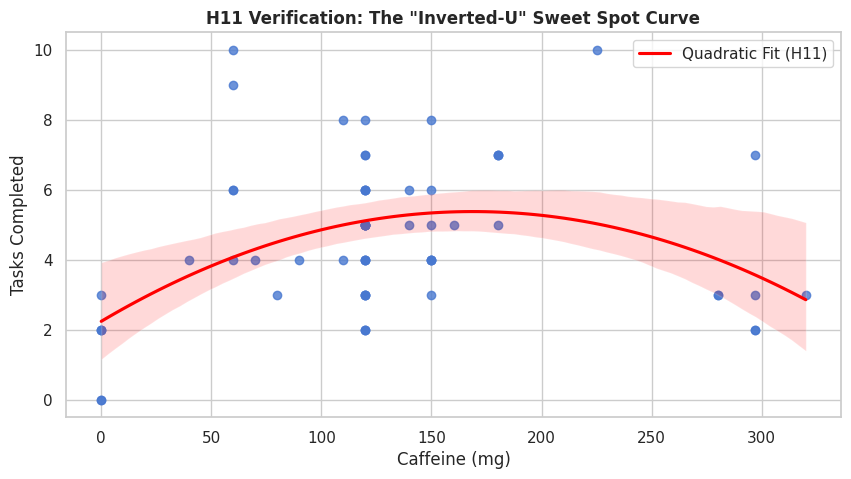

In [123]:
plt.figure(figsize=(10, 5))
sns.regplot(x='Caffeine_Amount_mg', y='Tasks_Completed', data=df_clean, order=2,
            line_kws={'color':'red', 'label':'Quadratic Fit (H11)'})

plt.title('H11 Verification: The "Inverted-U" Sweet Spot Curve', fontweight='bold')
plt.xlabel('Caffeine (mg)'); plt.ylabel('Tasks Completed'); plt.legend()
plt.show()

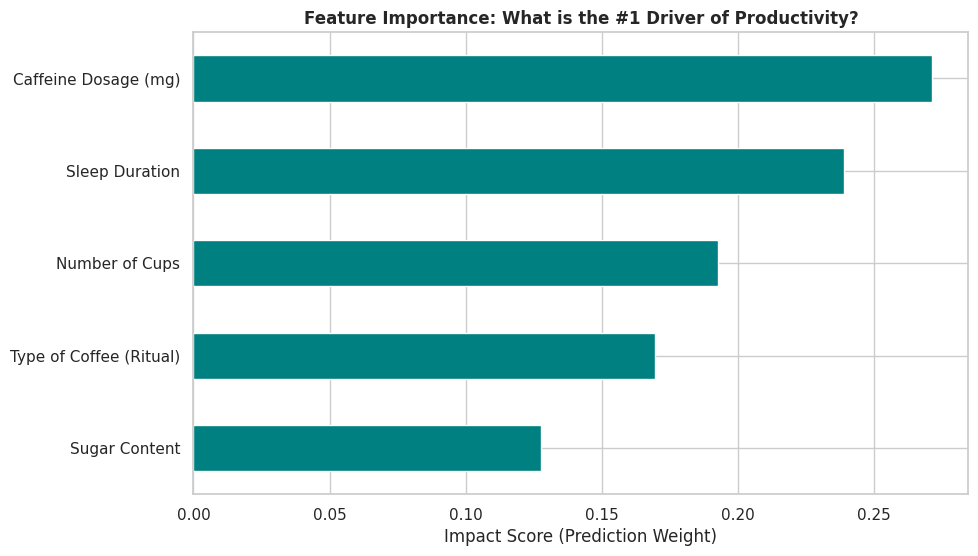

In [124]:
df_ml = df_clean.copy()
df_ml['Type_of_Coffee_Code'] = df_ml['Type_of_Coffee'].astype('category').cat.codes

# 2. Define Features
features = ['Caffeine_Amount_mg', 'Sleep_Hours', 'Est_Sugar_g', 'Coffee_Intake', 'Type_of_Coffee_Code']
X = df_ml[features].fillna(0)
y = df_ml['Tasks_Completed']

# 3. Train Model
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)

# 4. Clean up names for the chart
feature_names = {
    'Caffeine_Amount_mg': 'Caffeine Dosage (mg)',
    'Sleep_Hours': 'Sleep Duration',
    'Est_Sugar_g': 'Sugar Content',
    'Coffee_Intake': 'Number of Cups',
    'Type_of_Coffee_Code': 'Type of Coffee (Ritual)'
}
importance_series = pd.Series(rf.feature_importances_, index=features).rename(index=feature_names)

# 5. Visualize Top 5
plt.figure(figsize=(10, 6))
importance_series.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance: What is the #1 Driver of Productivity?', fontweight='bold')
plt.xlabel('Impact Score (Prediction Weight)')
plt.show()